In [1]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tqdm ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importa las librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # Para gráficos estadísticos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm  # Para mostrar una barra de progreso

# Definición del símbolo y las fechas
TICKER = '^GSPC' # Símbolo del S&P500

# Descarga de los datos
datos_sp500 = yf.download(TICKER, start='2023-01-04', end='2025-09-01')

# Mostrar las primeras filas para verificar
print(f"Datos descargados para {TICKER}:")
print(datos_sp500.head())
print(datos_sp500.tail())

# Seleccionar la columna de los precios de cierre para el cálculo de las rentabilidades
precios_cierre = datos_sp500['Close']

# Calcular las rentabilidades diarias (pct_change) (r = (Pi - Pi-1) / Pi-1)
# El primer valor no es obtenible al no haber datos del día anterior
rentabilidades = precios_cierre.pct_change().dropna() # Elimina los valores nulos (NaN)
rentabilidades = rentabilidades.rename(columns={'^GSPC': 'Rentabilidad'})


# Mostrar las primeras filas y estadísticas
print("\nPrimeras rentabilidades calculadas:")
print(rentabilidades.head())
print("\nEstadísticas de las rentabilidades:")
print(rentabilidades.describe()) # Separa los datos en 4 grupos y calcula la media de la rentabilidad


C:\Users\Usuario\AppData\Local\Temp\ipykernel_2860\2659060809.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos_sp500 = yf.download(TICKER, start='2023-01-04', end='2025-09-01')
[*********************100%***********************]  1 of 1 completed

Datos descargados para ^GSPC:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2023-01-04  3852.969971  3873.159912  3815.770020  3840.360107  4414080000
2023-01-05  3808.100098  3839.739990  3802.419922  3839.739990  3893450000
2023-01-06  3895.080078  3906.189941  3809.560059  3823.370117  3923560000
2023-01-09  3892.090088  3950.570068  3890.419922  3910.820068  4311770000
2023-01-10  3919.250000  3919.830078  3877.290039  3888.570068  3851030000
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2025-08-25  6439.319824  6466.890137  6438.060059  6457.669922  4059070000
2025-08-26  6465.939941  6468.370117  6429.209961  6435.490234  486768

In [3]:
# 1. Calcular la media y la desviación estándar 
media = rentabilidades.mean().item() # Extrae el valor de un serie 
desviacion = rentabilidades.std().item()

# 2. Definir los límites de exclusión (más/menos 2 desviaciones típicas)
limite_inferior = media - (2 * desviacion)
limite_superior = media + (2 * desviacion)

# 3. Contar y mostrar los outliers que serán eliminados
outliers = rentabilidades[
    (rentabilidades < limite_inferior) |
    (rentabilidades > limite_superior)
]

print(f"\nSe encontraron {len(outliers)} observaciones atípicas que serán eliminadas.")
print(f"Límite Inferior (mu - 2*sigma): {limite_inferior:.6f}") # Hasta 6 decimales
print(f"Límite Superior (mu + 2*sigma): {limite_superior:.6f}\n")


# 4. Aplicar el filtrado: crear un nuevo DataFrame sin los outliers
rentabilidades_filtradas = rentabilidades[
    (rentabilidades >= limite_inferior) &
    (rentabilidades <= limite_superior)
].copy()

#eliminar las filas con valores NaN
rentabilidades_filtradas = rentabilidades_filtradas.dropna()
rentabilidades_filtradas.rename(columns={'^GSPC': 'Rentabilidad'})
print(rentabilidades_filtradas.head())

# 5. Mostrar el tamaño del nuevo conjunto de datos
print("-" * 50)
print(f"Rentabilidades originales: {len(rentabilidades)} días")
print(f"Rentabilidades filtradas: {len(rentabilidades_filtradas)} días")


Se encontraron 665 observaciones atípicas que serán eliminadas.
Límite Inferior (mu - 2*sigma): -0.018680
Límite Superior (mu + 2*sigma): 0.020329

Ticker      Rentabilidad
Date                    
2023-01-05     -0.011646
2023-01-09     -0.000768
2023-01-10      0.006978
2023-01-11      0.012849
2023-01-12      0.003416
--------------------------------------------------
Rentabilidades originales: 665 días
Rentabilidades filtradas: 644 días


In [4]:
# 1. Calcular las métricas
media = rentabilidades_filtradas.mean()
varianza = rentabilidades_filtradas.var()
sesgo = rentabilidades_filtradas.skew()
# Usamos el método .kurt() de Pandas para la curtosis (que por defecto es la curtosis en exceso)
kurtosis = rentabilidades_filtradas.kurt()

# 2. Crear una tabla de resultados (DataFrame) para una presentación clara
resultados_estadisticos = pd.DataFrame({
    'Métrica': ['Media (μ)', 'Varianza (σ²)', 'Sesgo (Skewness)', 'Curtosis (Kurtosis)'],
    'Valor': [media, varianza, sesgo, kurtosis]
})

print("### Tabla de Resultados de Estadísticas Descriptivas (Serie Tratada) ###")
# Formateamos la tabla para que los valores se muestren con 6 decimales para precisión
print(resultados_estadisticos.set_index('Métrica'))

### Tabla de Resultados de Estadísticas Descriptivas (Serie Tratada) ###
                                                              Valor
Métrica                                                            
Media (μ)            Ticker
Rentabilidad    0.000964
dtype: float64
Varianza (σ²)        Ticker
Rentabilidad    0.000057
dtype: float64
Sesgo (Skewness)     Ticker
Rentabilidad   -0.147646
dtype: float64
Curtosis (Kurtosis)  Ticker
Rentabilidad   -0.027784
dtype: float64


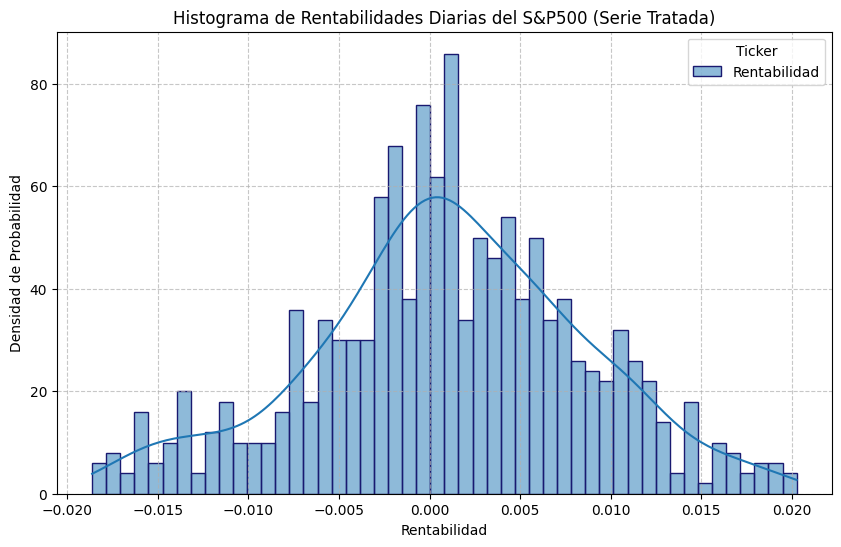

In [5]:
# Crear el histograma
plt.figure(figsize=(10, 6))
sns.histplot(rentabilidades_filtradas, bins=50, kde=True, stat='density', color='skyblue', edgecolor='midnightblue')
# kde=True añade una estimación de la densidad de probabilidad
# stat='density' normaliza el histograma para que el área total sea 1

plt.title('Histograma de Rentabilidades Diarias del S&P500 (Serie Tratada)')
plt.xlabel('Rentabilidad')
plt.ylabel('Densidad de Probabilidad')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
# Definir el número de rezagos (lags) a utilizar
NUM_LAGS = 5


# Definir el número de re
# Crear las variables rezagadas (R_t-1 a R_t-5)
for i in range(1, NUM_LAGS + 1):
    # .shift(i) desplaza la serie i posiciones hacia abajo (hacia el pasado)
    rentabilidades_filtradas[f'R_t-{i}'] = rentabilidades_filtradas['Rentabilidad'].shift(i)

print("Variables rezagadas creadas con éxito.")

# Eliminar las primeras 5 filas que contienen NaN después de la operación de shift
# Estas son las filas "no completas"
rentabilidades_filtradas = rentabilidades_filtradas.dropna()

print("\n### Matriz Final (Comienza en la 6ta Observación) ###")
print(f"Total de observaciones completas para el modelo: {len(rentabilidades_filtradas)}")
print(rentabilidades_filtradas.head())

# Variables Independientes (X): Todas las columnas *excepto* 'Rentabilidad'
X = rentabilidades_filtradas.drop('Rentabilidad', axis=1)

# Variable Dependiente (Y): La rentabilidad actual
Y = rentabilidades_filtradas['Rentabilidad']

print(f"\nMatriz X (Predictoras) lista. Columnas: {list(X.columns)}")
print(f"Vector Y (Objetivo) listo. Tamaño: {len(Y)}")

Variables rezagadas creadas con éxito.

### Matriz Final (Comienza en la 6ta Observación) ###
Total de observaciones completas para el modelo: 639
Ticker      Rentabilidad     R_t-1     R_t-2     R_t-3     R_t-4     R_t-5
Date                                                                      
2023-01-13      0.003997  0.003416  0.012849  0.006978 -0.000768 -0.011646
2023-01-17     -0.002030  0.003997  0.003416  0.012849  0.006978 -0.000768
2023-01-18     -0.015563 -0.002030  0.003997  0.003416  0.012849  0.006978
2023-01-19     -0.007638 -0.015563 -0.002030  0.003997  0.003416  0.012849
2023-01-20      0.018918 -0.007638 -0.015563 -0.002030  0.003997  0.003416

Matriz X (Predictoras) lista. Columnas: ['R_t-1', 'R_t-2', 'R_t-3', 'R_t-4', 'R_t-5']
Vector Y (Objetivo) listo. Tamaño: 639


In [7]:

# Definir el punto de corte (80% para entrenamiento)
tamaño_total = len(rentabilidades_filtradas)
punto_corte = int(tamaño_total * 0.8)

# Dividir el conjunto de entrenamiento (Train) - Datos más antiguos
X_train = X.iloc[:punto_corte]
Y_train = Y.iloc[:punto_corte]

# Dividir el conjunto de prueba (Test) - Datos más recientes
X_test = X.iloc[punto_corte:]
Y_test = Y.iloc[punto_corte:]

print("--- División de Datos ---")
print(f"Total de observaciones utilizadas: {tamaño_total}")
print(f"Conjunto de Entrenamiento (80%): {len(X_train)} días")
print(f"Conjunto de Prueba (20%): {len(X_test)} días")



--- División de Datos ---
Total de observaciones utilizadas: 639
Conjunto de Entrenamiento (80%): 511 días
Conjunto de Prueba (20%): 128 días


In [8]:
# 1. Crear una instancia del modelo de Regresión Lineal
modelo_regresion = LinearRegression()

# 2. Ajustar el modelo (Entrenamiento)
modelo_regresion.fit(X_train, Y_train)

print("\n Modelo de Regresión Lineal Múltiple (AR(5)) entrenado con éxito.")

# Obtener los coeficientes y el intercepto
intercepto = modelo_regresion.intercept_ #valores de beta a 0
coeficientes = modelo_regresion.coef_    #valores de beta reales

# Crear un DataFrame para visualizar
columnas_rezago = [f'R_t-{i}' for i in range(1, NUM_LAGS + 1)]
coeficientes_df = pd.DataFrame({
    'Variable': ['Intercepto'] + columnas_rezago,
    'Coeficiente (Beta)': [intercepto] + list(coeficientes)
})

print("\n### Coeficientes del Modelo Lineal (Pesos) ###")
print(coeficientes_df.set_index('Variable').apply(lambda x: pd.Series([f"{val:.6f}" for val in x], index=x.index)))

# Análisis
print("\nAnálisis Crítico de Coeficientes:")
if all(abs(coef) < 0.05 for coef in coeficientes):
    print("La mayoría de los coeficientes son extremadamente cercanos a cero.")
    print("Esto sugiere que la influencia lineal de las rentabilidades pasadas es casi nula, lo cual es la expectativa en un mercado eficiente.")


 Modelo de Regresión Lineal Múltiple (AR(5)) entrenado con éxito.

### Coeficientes del Modelo Lineal (Pesos) ###
           Coeficiente (Beta)
Variable                     
Intercepto           0.001150
R_t-1                0.001923
R_t-2               -0.058752
R_t-3               -0.063248
R_t-4                0.012887
R_t-5               -0.095115

Análisis Crítico de Coeficientes:


In [9]:

# Generar las predicciones del modelo (DENTRO DE LA MUESTRA)
Y_pred_train = modelo_regresion.predict(X_train)

# Crear un DataFrame para visualizar y comparar (las dos columnas requeridas)
df_calibrado = pd.DataFrame({
    'Rendimiento Real (Y_train)': Y_train,
    'Rendimiento Predicho (Y_pred_train)': Y_pred_train
})

print("Columnas de rendimiento real y predicho creadas con éxito.")
print("\nEjemplo de Predicciones vs. Real (Entrenamiento):")
print(df_calibrado.head())



Columnas de rendimiento real y predicho creadas con éxito.

Ejemplo de Predicciones vs. Real (Entrenamiento):
            Rendimiento Real (Y_train)  Rendimiento Predicho (Y_pred_train)
Date                                                                       
2023-01-13                    0.003997                             0.001058
2023-01-17                   -0.002030                             0.000307
2023-01-18                   -0.015563                             0.000197
2023-01-19                   -0.007638                            -0.000192
2023-01-20                    0.018918                             0.001904


In [10]:
# 1. Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(Y_train, Y_pred_train)

# 2. Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(Y_train, Y_pred_train)

# Función para calcular el MAPE de forma robusta
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitamos divisiones por cero o valores cercanos a cero (donde MAPE falla)
    # Se añade un eps (epsilon) al denominador para estabilidad si el valor es 0.
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

mape = mean_absolute_percentage_error(Y_train, Y_pred_train)

# Crear la tabla de resultados
metricas_calibracion = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'MAPE (%)', 'RMSE (Para referencia)'],
    'Valor': [mse, mae, mape, np.sqrt(mse)]
})

print("\n### Métricas de Calidad de Calibrado (DENTRO DE LA MUESTRA) ###")
print(metricas_calibracion.set_index('Métrica').apply(lambda x: pd.Series([f"{val:.6f}" if idx != 2 else f"{val:.2f}%" for idx, val in enumerate(x)], index=x.index)))


### Métricas de Calidad de Calibrado (DENTRO DE LA MUESTRA) ###
                           Valor
Métrica                         
MSE                     0.000056
MAE                     0.005866
MAPE (%)                 186.04%
RMSE (Para referencia)  0.007453


In [11]:
# Generar predicciones para el Modelo AR(5) (ya entrenado)
Y_pred_AR5 = modelo_regresion.predict(X_test)

# Generar predicciones para el Modelo Base (Paseo Aleatorio: R_t = 0)
Y_pred_Base = np.zeros(len(Y_test))

# La rentabilidad real se mantiene (Y_test)

# 1. Calcular Métricas para el Modelo AR(5)
mse_AR5 = mean_squared_error(Y_test, Y_pred_AR5)
mae_AR5 = mean_absolute_error(Y_test, Y_pred_AR5)

# 2. Calcular Métricas para el Modelo Base (R_t = 0)
mse_Base = mean_squared_error(Y_test, Y_pred_Base)
mae_Base = mean_absolute_error(Y_test, Y_pred_Base)

# Crear la tabla comparativa
df_comparacion = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'RMSE'],
    'Modelo AR(5)': [
        mse_AR5,
        mae_AR5,
        np.sqrt(mse_AR5),
    ],
    'Modelo Base (R_t=0)': [
        mse_Base,
        mae_Base,
        np.sqrt(mse_Base),
       
    ]
})

# Formatear y mostrar
print("\n### Comparación de Modelos (FUERA DE LA MUESTRA) ###")
print(df_comparacion.set_index('Métrica'))


### Comparación de Modelos (FUERA DE LA MUESTRA) ###
         Modelo AR(5)  Modelo Base (R_t=0)
Métrica                                   
MSE          0.000061             0.000061
MAE          0.005955             0.005954
RMSE         0.007816             0.007784


In [12]:

# --- Configuración del Modelo de Ventana Deslizante ---
WINDOW_SIZE = 30  # Usar los últimos 30 días para entrenar
predictions_sliding = [] # Lista para guardar las predicciones
actuals_sliding = []     # Lista para guardar los valores reales correspondientes

print(f"Iniciando predicción con ventana deslizante de {WINDOW_SIZE} días...")

# Iteramos a través de cada día del conjunto de prueba para hacer una predicción
# tqdm es para visualizar el progreso del bucle

for i in tqdm(range(len(X_test)), desc="Procesando Ventana Deslizante"):
    
    # 1. Localizar el punto final de la ventana de entrenamiento en el DataFrame original (X, Y)
    # El índice de la i-ésima observación de prueba nos da el punto final
    end_loc_index = X.index.get_loc(X_test.index[i])
    
    # 2. Definir la ventana de entrenamiento (los 30 días ANTERIORES)
    start_loc_index = end_loc_index - WINDOW_SIZE
    X_window = X.iloc[start_loc_index:end_loc_index]
    Y_window = Y.iloc[start_loc_index:end_loc_index]
    
    # 3. Crear y entrenar un nuevo modelo SOLO con los datos de esa ventana
    model_iterativo = LinearRegression()
    model_iterativo.fit(X_window, Y_window)
    
    # 4. Predecir el siguiente valor usando la fila actual de X_test
    # Usamos .iloc[[i]] para mantener el formato de DataFrame
    prediction = model_iterativo.predict(X_test.iloc[[i]])[0] # [0] para extraer el valor numérico
    
    # 5. Guardar la predicción y el valor real
    predictions_sliding.append(prediction)
    actuals_sliding.append(Y_test.iloc[i])

print(f"\nPredicción completada. Se generaron {len(predictions_sliding)} predicciones.")

Iniciando predicción con ventana deslizante de 30 días...


Procesando Ventana Deslizante:   0%|          | 0/128 [00:00<?, ?it/s]


Predicción completada. Se generaron 128 predicciones.


In [13]:
# --- Evaluación del Modelo de Ventana Deslizante ---
mse_sliding = mean_squared_error(actuals_sliding, predictions_sliding)
mae_sliding = mean_absolute_error(actuals_sliding, predictions_sliding)
rmse_sliding = np.sqrt(mse_sliding)

# --- Evaluación del Modelo Base (Paseo Aleatorio) sobre el mismo conjunto ---
# Las predicciones del modelo base son siempre 0
pred_base_sliding = np.zeros(len(actuals_sliding))

mse_base = mean_squared_error(actuals_sliding, pred_base_sliding)
mae_base = mean_absolute_error(actuals_sliding, pred_base_sliding)
rmse_base = np.sqrt(mse_base)

# --- Crear la tabla comparativa ---
df_comparacion_final = pd.DataFrame({
    'Métrica': ['MSE', 'MAE', 'RMSE'],
    'Modelo AR(5) Deslizante': [mse_sliding, mae_sliding, rmse_sliding],
    'Modelo Base (Paseo Aleatorio)': [mse_base, mae_base, rmse_base]
})

print("### Comparación Final de Modelos Predictivos (FUERA DE LA MUESTRA) ###")
print(df_comparacion_final.set_index('Métrica'))

# --- Análisis de Resultados ---
print("\n--- Análisis de la Calidad Predictiva ---")
if mse_sliding >= mse_base and mae_sliding >= mae_base:
    print("El modelo AR(5) con ventana deslizante NO supera al modelo base (paseo aleatorio).")
    print("Sus errores (MSE y MAE) son iguales o mayores, lo que indica que no aporta valor predictivo.")
    print("Este resultado es consistente con la Hipótesis de los Mercados Eficientes.")
else:
    print("El modelo AR(5) con ventana deslizante muestra una ligera mejora sobre el modelo base.")
    print("Sin embargo, la diferencia en los errores es probablemente muy pequeña para ser considerada significativa en la práctica.")

### Comparación Final de Modelos Predictivos (FUERA DE LA MUESTRA) ###
         Modelo AR(5) Deslizante  Modelo Base (Paseo Aleatorio)
Métrica                                                        
MSE                     0.000076                       0.000061
MAE                     0.006853                       0.005954
RMSE                    0.008696                       0.007784

--- Análisis de la Calidad Predictiva ---
El modelo AR(5) con ventana deslizante NO supera al modelo base (paseo aleatorio).
Sus errores (MSE y MAE) son iguales o mayores, lo que indica que no aporta valor predictivo.
Este resultado es consistente con la Hipótesis de los Mercados Eficientes.


 RESULTADOS ESTRATEGIA DE INVERSIÓN 
Rentabilidad total estrategia: 6.83%
Rentabilidad total mercado (buy & hold): 12.84%
Número de días invertidos: 80 de 128


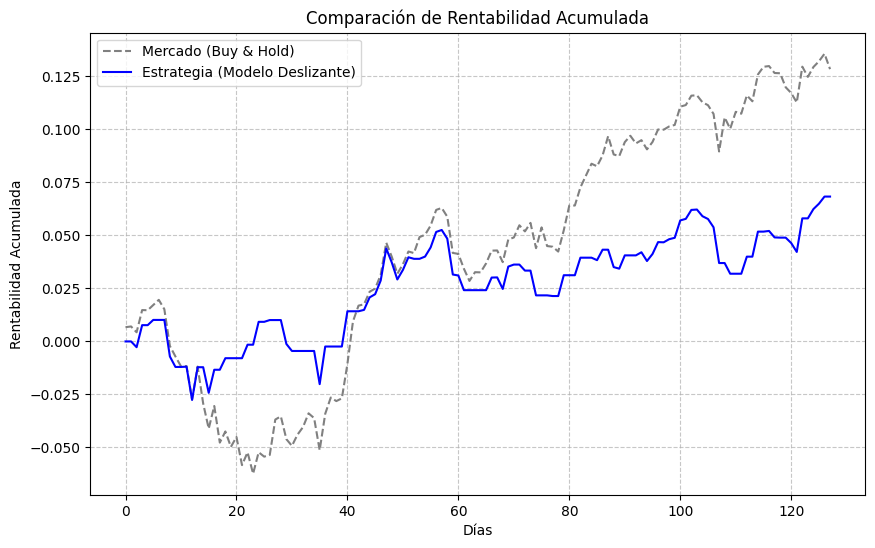

Precisión en la dirección del mercado: 52.34%


In [14]:
# ============================================
# Estrategia de inversión con el modelo deslizante
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Variables base ---
# predictions_sliding: predicciones del modelo
# rentabilidades_filtradas['Rentabilidad']: serie real de rendimientos

# Alineamos las longitudes (el modelo deslizante normalmente empieza más tarde)
# Suponemos que las predicciones_sliding corresponden a las últimas observaciones válidas:
y_pred_deslizante = np.array(predictions_sliding)
y_real_deslizante = rentabilidades_filtradas['Rentabilidad'].iloc[-len(y_pred_deslizante):].values

# --- 2. Generar señal de inversión ---
# Regla: invertimos solo si la predicción del rendimiento del día siguiente > 0
signal = (y_pred_deslizante > 0).astype(int)

# --- 3. Calcular rentabilidad diaria de la estrategia ---
strategy_returns = signal * y_real_deslizante

# --- 4. Rentabilidad acumulada de la estrategia y del mercado ---
cumulative_strategy = np.cumprod(1 + strategy_returns) - 1
cumulative_market = np.cumprod(1 + y_real_deslizante) - 1

# --- 5. Resultados finales numéricos ---
total_strategy_return = cumulative_strategy[-1] * 100
total_market_return = cumulative_market[-1] * 100

print("============================================")
print(" RESULTADOS ESTRATEGIA DE INVERSIÓN ")
print("============================================")
print(f"Rentabilidad total estrategia: {total_strategy_return:.2f}%")
print(f"Rentabilidad total mercado (buy & hold): {total_market_return:.2f}%")
print(f"Número de días invertidos: {signal.sum()} de {len(signal)}")

# --- 6. Gráfico comparativo ---
plt.figure(figsize=(10, 6))
plt.plot(cumulative_market, label='Mercado (Buy & Hold)', color='gray', linestyle='--')
plt.plot(cumulative_strategy, label='Estrategia (Modelo Deslizante)', color='blue')
plt.title('Comparación de Rentabilidad Acumulada')
plt.xlabel('Días')
plt.ylabel('Rentabilidad Acumulada')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- 7. Métrica adicional: precisión en la dirección ---
direction_accuracy = np.mean(
    ((signal == 1) & (y_real_deslizante > 0)) | ((signal == 0) & (y_real_deslizante <= 0))
)
print(f"Precisión en la dirección del mercado: {direction_accuracy * 100:.2f}%")
